In [3]:
# -*- coding: utf-8 -*- #

# Write libraries here #########################################
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from astroquery.gama import GAMA
from jupyterthemes import jtplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, cluster, preprocessing, mixture
from time import time
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
################################################################


# Showing 500 columns and rows #################################
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
################################################################


# NOT CHANGE (The PATH for directory) ##########################
CURRENT_DIR_NAME = os.path.dirname(os.path.abspath(__name__))
PATH_DATA = os.path.join(CURRENT_DIR_NAME, '../data/')
PATH_HIST = os.path.join(CURRENT_DIR_NAME, '../histogram/')
PATH_PLOT = os.path.join(CURRENT_DIR_NAME, '../plots/')
PATH_IMG = os.path.join(CURRENT_DIR_NAME, '../images/')
PATH_HTML = os.path.join(CURRENT_DIR_NAME, '../html/')
PATH_TEX = os.path.join(CURRENT_DIR_NAME, '../for_tex/')
################################################################

#When you make plots, jtplot is better.
jtplot.style(theme='grade3', context='notebook', fscale=3, spines=True, gridlines='--', ticks=False, grid=False)

In [2]:
# Read the data

DATA_GAMA_KCORRECTED = GAMA.query_sql('SELECT * FROM kcorr_auto_z00 LIMIT 1000000')
#DATA_GAMA_MAGPHYS = GAMA.query_sql('SELECT * FROM MagPhys LIMIT 1000000')
DATA_GAMA_FLUX = GAMA.query_sql('SELECT * FROM LambdarCat LIMIT 1000000')
#DATA_GAMA_GALEX = GAMA.query_sql('SELECT * FROM GalexPhot LIMIT 300000')
#DATA_GAMA_REDSHIFT = GAMA.query_sql('SELECT * FROM AATRunzResults LIMIT 1000000')

In [3]:
# Arrange the Astropy table for the analysis (Convert into pd.DataFrame, set index and select samples which have reliable redshift)
DATA_GAMA_FLUX = DATA_GAMA_FLUX.to_pandas().set_index('CATAID')
DATA_GAMA_KCORRECTED = DATA_GAMA_KCORRECTED.to_pandas().set_index('CATAID').loc[DATA_GAMA_KCORRECTED['NQ'] >= 3]
DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['FUV_flux'] > 0) & (DATA_GAMA_FLUX['NUV_flux'] > 0) &
                                    (DATA_GAMA_FLUX['u_flux'] > 0) & (DATA_GAMA_FLUX['g_flux'] > 0) & (DATA_GAMA_FLUX['r_flux'] > 0) & (DATA_GAMA_FLUX['i_flux'] > 0) & (DATA_GAMA_FLUX['z_flux'] > 0) & 
                                    (DATA_GAMA_FLUX['Y_flux'] > 0) & (DATA_GAMA_FLUX['J_flux'] > 0) & (DATA_GAMA_FLUX['H_flux'] > 0) & (DATA_GAMA_FLUX['K_flux'] > 0)].join(DATA_GAMA_KCORRECTED, how='inner')
DATA_GAMA_FLUX['FUV_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['FUV_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_FUV']
DATA_GAMA_FLUX['NUV_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['NUV_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_NUV']
DATA_GAMA_FLUX['U_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['u_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_U']
DATA_GAMA_FLUX['G_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['g_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_G']
DATA_GAMA_FLUX['R_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['r_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_R']
DATA_GAMA_FLUX['I_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['i_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_I']
DATA_GAMA_FLUX['Z_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['z_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_Z']
DATA_GAMA_FLUX['Y_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['Y_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_Y']
DATA_GAMA_FLUX['J_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['J_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_J']
DATA_GAMA_FLUX['H_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['H_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_H']
DATA_GAMA_FLUX['K_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['K_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_K']
DATA_GAMA_FLUX['R-K'] = DATA_GAMA_FLUX['R_flux_kcorrected'] - DATA_GAMA_FLUX['K_flux_kcorrected']
DATA_GAMA_FLUX['NUV-R'] = DATA_GAMA_FLUX['NUV_flux_kcorrected'] - DATA_GAMA_FLUX['R_flux_kcorrected']
DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['I_flux_kcorrected'] < 22.5]
# Show the details of our samples for manifold learning
display(DATA_GAMA_FLUX.describe())

,RA,DEC,FUV_flux,FUV_fluxerr,NUV_flux,NUV_fluxerr,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,X_flux,X_fluxerr,Y_flux,Y_fluxerr,J_flux,J_fluxerr,H_flux,H_fluxerr,K_flux,K_fluxerr,W1_flux,W1_fluxerr,W2_flux,W2_fluxerr,W3_flux,W3_fluxerr,W4_flux,W4_fluxerr,P100_flux,P100_fluxerr,P160_flux,P160_fluxerr,S250_flux,S250_fluxerr,S350_flux,S350_fluxerr,S500_flux,S500_fluxerr,Z_TONRY,NQ,KCORR_FUV,KCORR_NUV,KCORR_U,KCORR_G,KCORR_R,KCORR_I,KCORR_Z,KCORR_Y,KCORR_J,KCORR_H,KCORR_K,PCOEFF_R_1,PCOEFF_R_2,PCOEFF_R_3,PCOEFF_R_4,PCOEFF_R_5,COEFFS_1,COEFFS_2,COEFFS_3,COEFFS_4,COEFFS_5,CHI2,MASS,INTSFH,METS,B300,B1000,FUV_flux_kcorrected,NUV_flux_kcorrected,U_flux_kcorrected,G_flux_kcorrected,R_flux_kcorrected,I_flux_kcorrected,Z_flux_kcorrected,Y_flux_kcorrected,J_flux_kcorrected,H_flux_kcorrected,K_flux_kcorrected,R-K,NUV-R
count,75574.000000,75574.000000,7.557400e+04,7.557400e+04,7.557400e+04,7.557400e+04,7.557400e+04,7.557400e+04,7.557400e+04,7.557400e+04,7.557400e+04,7.557400e+04,75574.000000,7.557400e+04,7.557400e+04,7.557400e+04,75574.000000,75574.000000,7.557400e+04,75574.000000,7.557400e+04,75574.000000,7.557400e+04,75574.000000,7.557400e+04,75574.000000,75574.000000,75574.000000,7.557400e+04,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,7.557400e+04,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,7.557400e+04,7.557400e+04,7.557400e+04,75574.000000,7.557400e+04,75574.000000,7.557400e+04,7.557400e+04,75574.000000,7.557400e+04,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000,75574.000000
mean,189.525509,0.377204,9.711226e-06,1.451349e-06,1.771329e-05,6.986411e-06,3.948194e-05,5.821913e-06,1.230183e-04,6.782877e-06,2.399978e-04,9.456078e-06,0.000342,1.291614e-05,4.184932e-04,2.705417e-05,-4.864111,-4.864510,5.073883e-04,0.000036,5.965440e-04,0.000033,7.279837e-04,0.000037,7.418153e-04,0.000038,0.000394,0.000070,2.700602e-04,0.000067,0.000679,0.000142,0.001325,0.000923,-134.514902,-134.523487,-134.865095,-134.878101,-145.637767,-145.651613,-145.607196,-145.611849,-145.520031,-145.518102,1.992923e-01,4.120901,0.254465,0.121371,0.424134,0.453106,0.201110,0.062011,0.069842,0.097778,-0.019109,0.003285,-0.327125,-0.001007,1.726275,-6.285040,12.578742,-4.711374,3.865146e-06,1.077159e-09,7.270128e-07,0.000009,1.738131e-07,2.534739,2.855200e+10,5.127910e+10,0.029642,2.012783e-02,0.267084,22.996506,21.800378,21.190014,19.937708,18.843749,18.315084,18.111688,17.934712,17.647337,17.454279,17.024029,1.819719,2.956629
std,33.818514,1.356455,7.060734e-05,1.110512e-05,1.183997e-04,7.323124e-05,3.182354e-04,2.832376e-05,1.012642e-03,2.634539e-05,1.813760e-03,3.128646e-05,0.002512,3.994223e-05,3.050874e-03,9.461741e-05,69.541858,69.541830,3.454813e-03,0.000169,4.020601e-03,0.000131,4.786742e-03,0.000116,4.087450e-03,0.000131,0.002393,0.000199,1.434210e-03,0.000230,0.006058,0.000380,0.011875,0.000911,341.048494,341.045012,341.432715,341.427477,352.567654,352.561913,352.524076,352.522151,352.428941,352.429737,1.119618e-01,0.375896,0.547017,0.250736,0.363832,0.340957,0.149239,0.144465,0.109049,0.124736,0.095115,0.074073,0.133371,0.003244,0.689752,6.678413,18.479903,17.638017,2.263099e-05,6.226626e-09,2.969528e-06,0.000057,8.623680e-07,26.289576,1.298832e+11,2.250306e+11,0.007781,4.517762e-02,0.188686,2.439875,1.707184,1.463390,1.271379,0.991024,0.970257,0.968422,0.979272,0.993969,1.001170,0.981479,0.707861,1.650233
min,129.000109,-2.993768,3.392050e-40,5.765690e-09,1.859400e-35,4.996250e-10,3.878410e-12,2.499510e-07,3.557740e-10,1.292490e-07,1.005970e-08,1.932670e-07,0.000004,2.658190e-0

## Show the distribution of redshift of our samples

# of samples = 75574


Text(0.5, 1.0, 'The redshift distribution of samples')

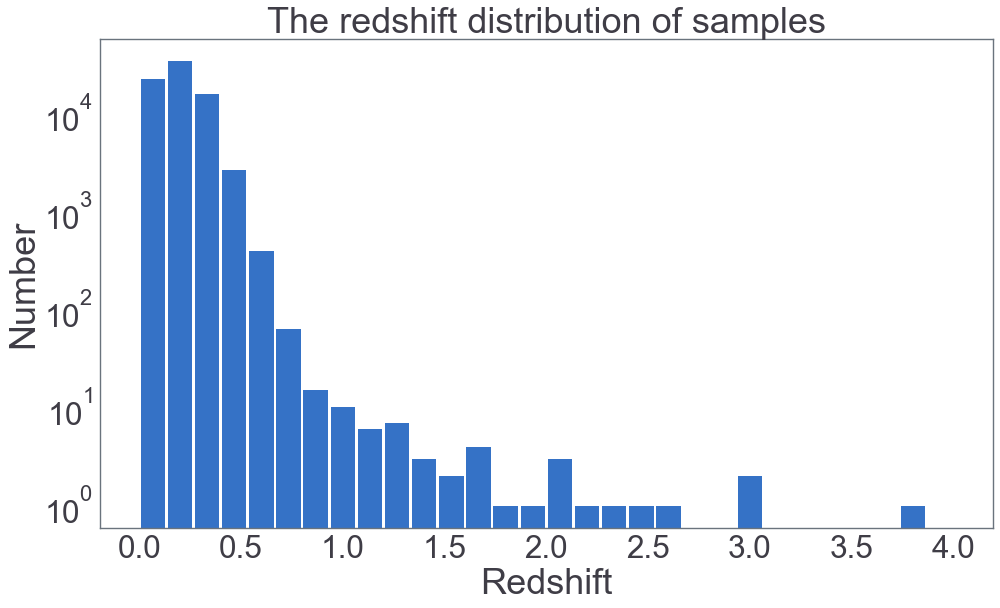

In [4]:

plt.figure(figsize=(16, 9))
plt.hist(DATA_GAMA_FLUX['Z_TONRY'], range=[0, 4], bins=30,  rwidth=0.9)
print('# of samples = %s'%(len(DATA_GAMA_FLUX['Z_TONRY'])))
plt.xlabel('Redshift')
plt.ylabel('Number')
plt.yscale('log')
plt.title('The redshift distribution of samples')


## Color-color plot (NUV-r and r-K)

(-0.3, 8.5)

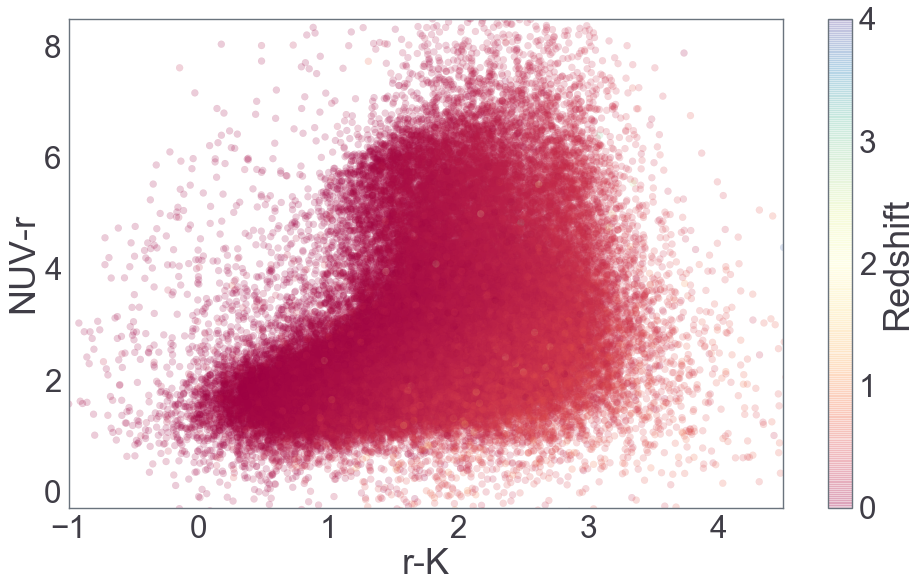

In [5]:
#  Color-color plot with colorbars based on redshift
plt.figure(figsize=(16, 9))
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['Z_TONRY'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Redshift')
plt.clim(vmin=0, vmax=4)
plt.xlabel('r-K')
plt.xlim([-1, 4.5])
plt.ylabel('NUV-r')
plt.ylim([-0.3, 8.5])

# Variational Bayesian Gaussian Mixture (VBGMM) for the classification

In [6]:
# Select columns for classification and manifold learning
data_for_manifoldlearning = DATA_GAMA_FLUX[['Z_TONRY', 'FUV_flux_kcorrected', 'NUV_flux_kcorrected',
                                            'U_flux_kcorrected', 'G_flux_kcorrected', 'R_flux_kcorrected', 'I_flux_kcorrected', 'Z_flux_kcorrected',
                                            'Y_flux_kcorrected', 'J_flux_kcorrected', 'H_flux_kcorrected', 'K_flux_kcorrected']]

/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


<BarContainer object of 12 artists>

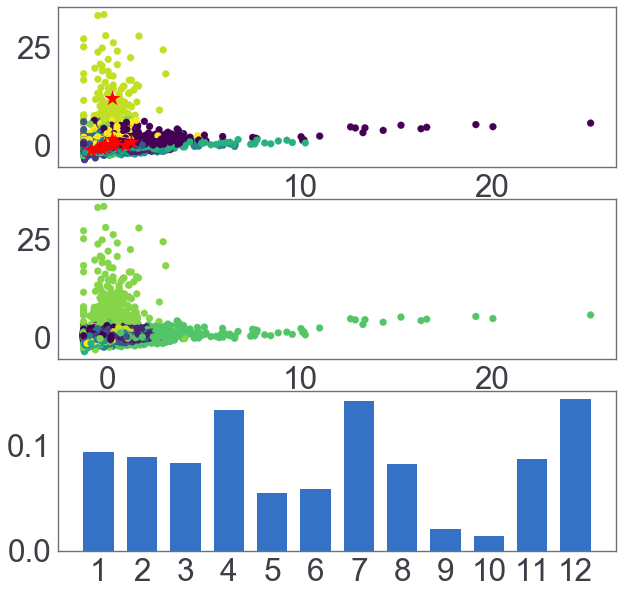

In [7]:

X = data_for_manifoldlearning

# RobustScaler uses [0.25, 0.75] samples
#sc=preprocessing.StandardScaler()
sc=preprocessing.RobustScaler()
sc.fit(X)
X_norm=sc.transform(X)

plt.figure(figsize=(10,10))
x=X_norm[:,0]
y=X_norm[:,1]

#Execute the K-means
km=cluster.KMeans(n_clusters=12)
z_km=km.fit(X_norm)

# Plot the K-means result
plt.subplot(311)
plt.scatter(x,y, c=z_km.labels_)
plt.scatter(z_km.cluster_centers_[:,0],z_km.cluster_centers_[:,1],s=250, marker='*',c='red')

# Execute the VBGMM
vbgm = mixture.BayesianGaussianMixture(n_components=12)
vbgm=vbgm.fit(X_norm)
labels=vbgm.predict(X_norm)

# Plot the VBGMM result
plt.subplot(312)
plt.scatter(x,y, c=labels)

# Plot the probability distribution calculated by VBGMM
#print(vbgm.weights_)
plt.subplot(313)
x_tick =np.array([1,2,3,4,5,6,7,8,9,10,11,12])
plt.bar(x_tick, vbgm.weights_, width=0.7, tick_label=x_tick)


In [8]:
# Add the label from VBGMM to the original pd.DataFrame
data_for_manifoldlearning = data_for_manifoldlearning.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))
DATA_GAMA_FLUX = DATA_GAMA_FLUX.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))

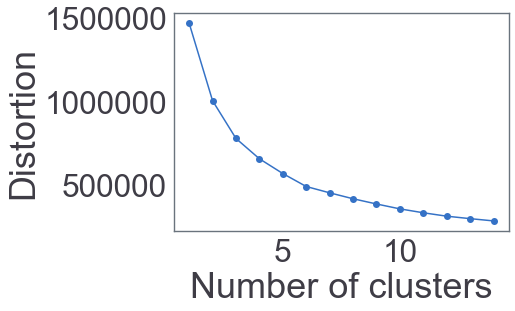

In [9]:
# How many clusters are the best for K-means?
distortions = []

for i in tnrange(1,15):
    km = cluster.KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        max_iter=300)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,15),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

label:0, center_point=(1.8269428092843294, 3.312124620565955)
# of samples : 6921
label:1, center_point=(2.6007975885511305, 2.3218151090021517)
# of samples : 6550
label:2, center_point=(2.074531262038939, 5.047852615069562)
# of samples : 6379
label:3, center_point=(2.1478127392615702, 2.3023171541121186)
# of samples : 10240
label:4, center_point=(1.592681727029742, 4.6750172204808855)
# of samples : 4120
label:5, center_point=(1.3130158998248231, 2.2125503131980695)
# of samples : 4218
label:6, center_point=(1.7601041329515876, 2.5925332401266905)
# of samples : 11063
label:7, center_point=(1.0313824048715305, 2.2138521016382224)
# of samples : 6245
label:8, center_point=(2.680886574550924, 2.4589084979537943)
# of samples : 1466
label:9, center_point=(1.7368514282276946, 6.748596092681115)
# of samples : 1000
label:10, center_point=(2.669842821017209, 4.384365885675311)
# of samples : 6485
label:11, center_point=(1.0675858369694105, 1.8049914369165623)
# of samples : 10887



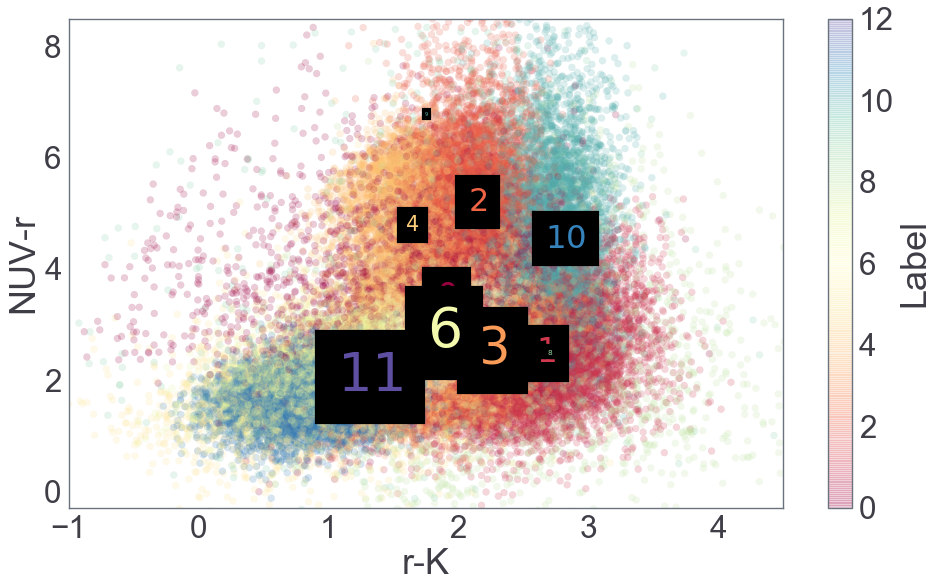

In [16]:
# Show the color-color plot with labels (each number on the plot shows the label number)

plt.figure(figsize=(16, 9))
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=data_for_manifoldlearning['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=12)
plt.xlabel('r-K')
plt.xlim([-1, 4.5])
plt.ylabel('NUV-r')
plt.ylim([-0.3, 8.5])

for i in tnrange(12):
    x_mean = np.mean(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i, 'R-K'])
    y_mean = np.mean(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i, 'NUV-R'])
    print('label:%s, center_point=(%s, %s)'%(i, x_mean, y_mean))
    print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i])))
    #plt.scatter(x_mean, y_mean, marker='$%s$'%(i), s=len(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i])/7, color=plt.cm.Spectral(i/11))
    plt.text(x_mean, y_mean, '$%s$'%(i), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i])/200, color=plt.cm.Spectral(i/11))
    

In [11]:
'''
n_components = 2
nparray_data_for_manifoldlearning = data_for_manifoldlearning.values
X = nparray_data_for_manifoldlearning
fig = plt.figure(figsize=(32, 27))

for i in tnrange(6):
    n_neighbors = i+10
    
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method='standard').fit_transform(X)
    t1 = time()
    ax = fig.add_subplot(321+i)
    ax.scatter(Y[:, 0], Y[:, 1], alpha=0.2, c=data_for_manifoldlearning['label'], cmap=plt.cm.Spectral)
    ax.set_title("Manifold Learning (LLE) with %i neighbors (%.2g sec)" % (n_neighbors, t1 - t0))
'''

'\nn_components = 2\nnparray_data_for_manifoldlearning = data_for_manifoldlearning.values\nX = nparray_data_for_manifoldlearning\nfig = plt.figure(figsize=(32, 27))\n\nfor i in tnrange(6):\n    n_neighbors = i+10\n    \n    t0 = time()\n    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,\n                                        eigen_solver=\'auto\',\n                                        method=\'standard\').fit_transform(X)\n    t1 = time()\n    ax = fig.add_subplot(321+i)\n    ax.scatter(Y[:, 0], Y[:, 1], alpha=0.2, c=data_for_manifoldlearning[\'label\'], cmap=plt.cm.Spectral)\n    ax.set_title("Manifold Learning (LLE) with %i neighbors (%.2g sec)" % (n_neighbors, t1 - t0))\n'